In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
train = pd.read_parquet('../notebooks/data/train.parquet')
train.head(2)
test = pd.read_parquet('notebooks/data/forecast.parquet')
test.rename(columns={'prediction': 'sales'}, inplace=True)
print(test.columns)

Index(['family', 'date', 'y', 'sales'], dtype='object')


In [23]:
len(train['family'].unique())

33

=== Error Summary ===
Mean Error: 68.36
Mean Absolute Error: 1770.64
Mean Percentage Error: -4.47%
RMSE: 5271.29


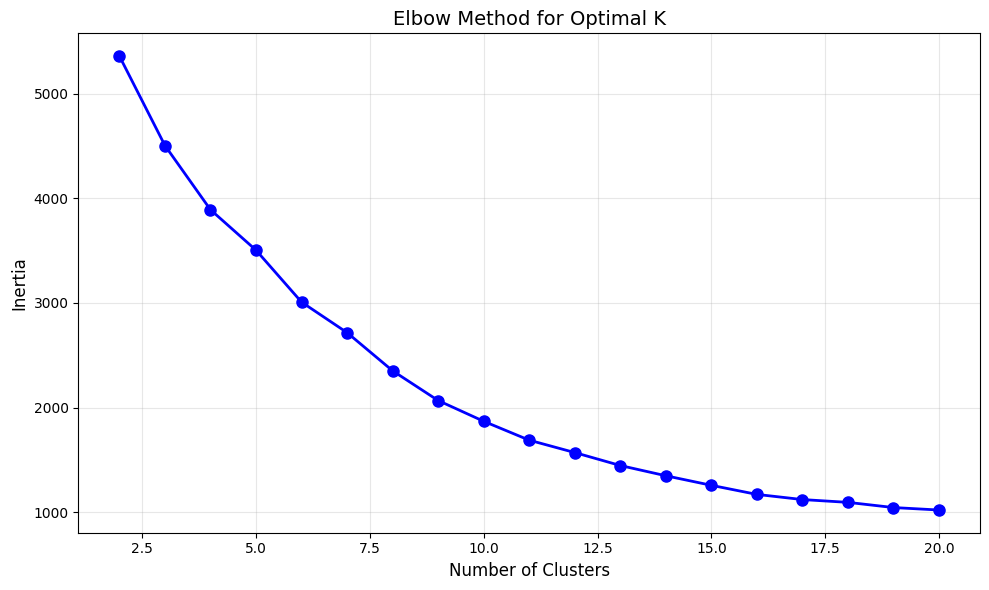

In [13]:

# # Example data structure matching your format
# train = pd.DataFrame({
#     'family': ['A', 'B', 'A', 'C', 'B'] * 100,
#     'date': pd.date_range('2023-01-01', periods=500),
#     'sales': np.random.randint(10, 100, 500)
# })

# test = pd.DataFrame({
#     'family': ['A', 'B', 'A', 'C', 'B'] * 50,
#     'date': pd.date_range('2023-06-15', periods=250),
#     'y': np.random.randint(10, 100, 250),  # actual values
#     'sales': np.random.randint(10, 100, 250)  # predictions
# })

# Feature engineering for test data
def add_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['family_encoded'] = df['family'].astype('category').cat.codes
    return df

test_fe = add_features(test)

# Calculate errors (y is actual, sales is prediction)
test_fe['error'] = test_fe['y'] - test_fe['sales']
test_fe['abs_error'] = np.abs(test_fe['error'])
test_fe['pct_error'] = (test_fe['error'] / test_fe['y']) * 100

# Replace infinite values from division by zero
test_fe['pct_error'] = test_fe['pct_error'].replace([np.inf, -np.inf], 0)

print("=== Error Summary ===")
print(f"Mean Error: {test_fe['error'].mean():.2f}")
print(f"Mean Absolute Error: {test_fe['abs_error'].mean():.2f}")
print(f"Mean Percentage Error: {test_fe['pct_error'].mean():.2f}%")
print(f"RMSE: {np.sqrt((test_fe['error']**2).mean()):.2f}")

# Prepare features for clustering
cluster_features = ['error', 'abs_error', 'pct_error', 'y', 'sales',
                   'day_of_week', 'month', 'family_encoded']
X_cluster = test_fe[cluster_features].copy()

# Handle any missing values
X_cluster = X_cluster.fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



=== Cluster Analysis ===

Cluster 0 (n=77, 8.3%):
  Mean Error: 2548.41
  Mean Abs Error: 14298.90
  Mean % Error: 2.11%
  Mean Actual (y): 192317.84
  Mean Prediction (sales): 189769.43
  Top families: {'BEVERAGES': 28, 'GROCERY I': 28, 'PRODUCE': 14, 'CLEANING': 7}

Cluster 1 (n=847, 91.7%):
  Mean Error: -157.09
  Mean Abs Error: 631.71
  Mean % Error: -5.07%
  Mean Actual (y): 10187.01
  Mean Prediction (sales): 10344.10
  Top families: {'AUTOMOTIVE': 28, 'BABY CARE': 28, 'SCHOOL AND OFFICE SUPPLIES': 28, 'PREPARED FOODS': 28, 'POULTRY': 28, 'PLAYERS AND ELECTRONICS': 28, 'PET SUPPLIES': 28, 'PERSONAL CARE': 28, 'MEATS': 28, 'MAGAZINES': 28, 'LIQUOR,WINE,BEER': 28, 'LINGERIE': 28, 'LAWN AND GARDEN': 28, 'LADIESWEAR': 28, 'HOME CARE': 28, 'HOME APPLIANCES': 28, 'HOME AND KITCHEN II': 28, 'HOME AND KITCHEN I': 28, 'HARDWARE': 28, 'GROCERY II': 28, 'FROZEN FOODS': 28, 'EGGS': 28, 'DELI': 28, 'DAIRY': 28, 'CELEBRATION': 28, 'BREAD/BAKERY': 28, 'BOOKS': 28, 'BEAUTY': 28, 'SEAFOOD': 28,

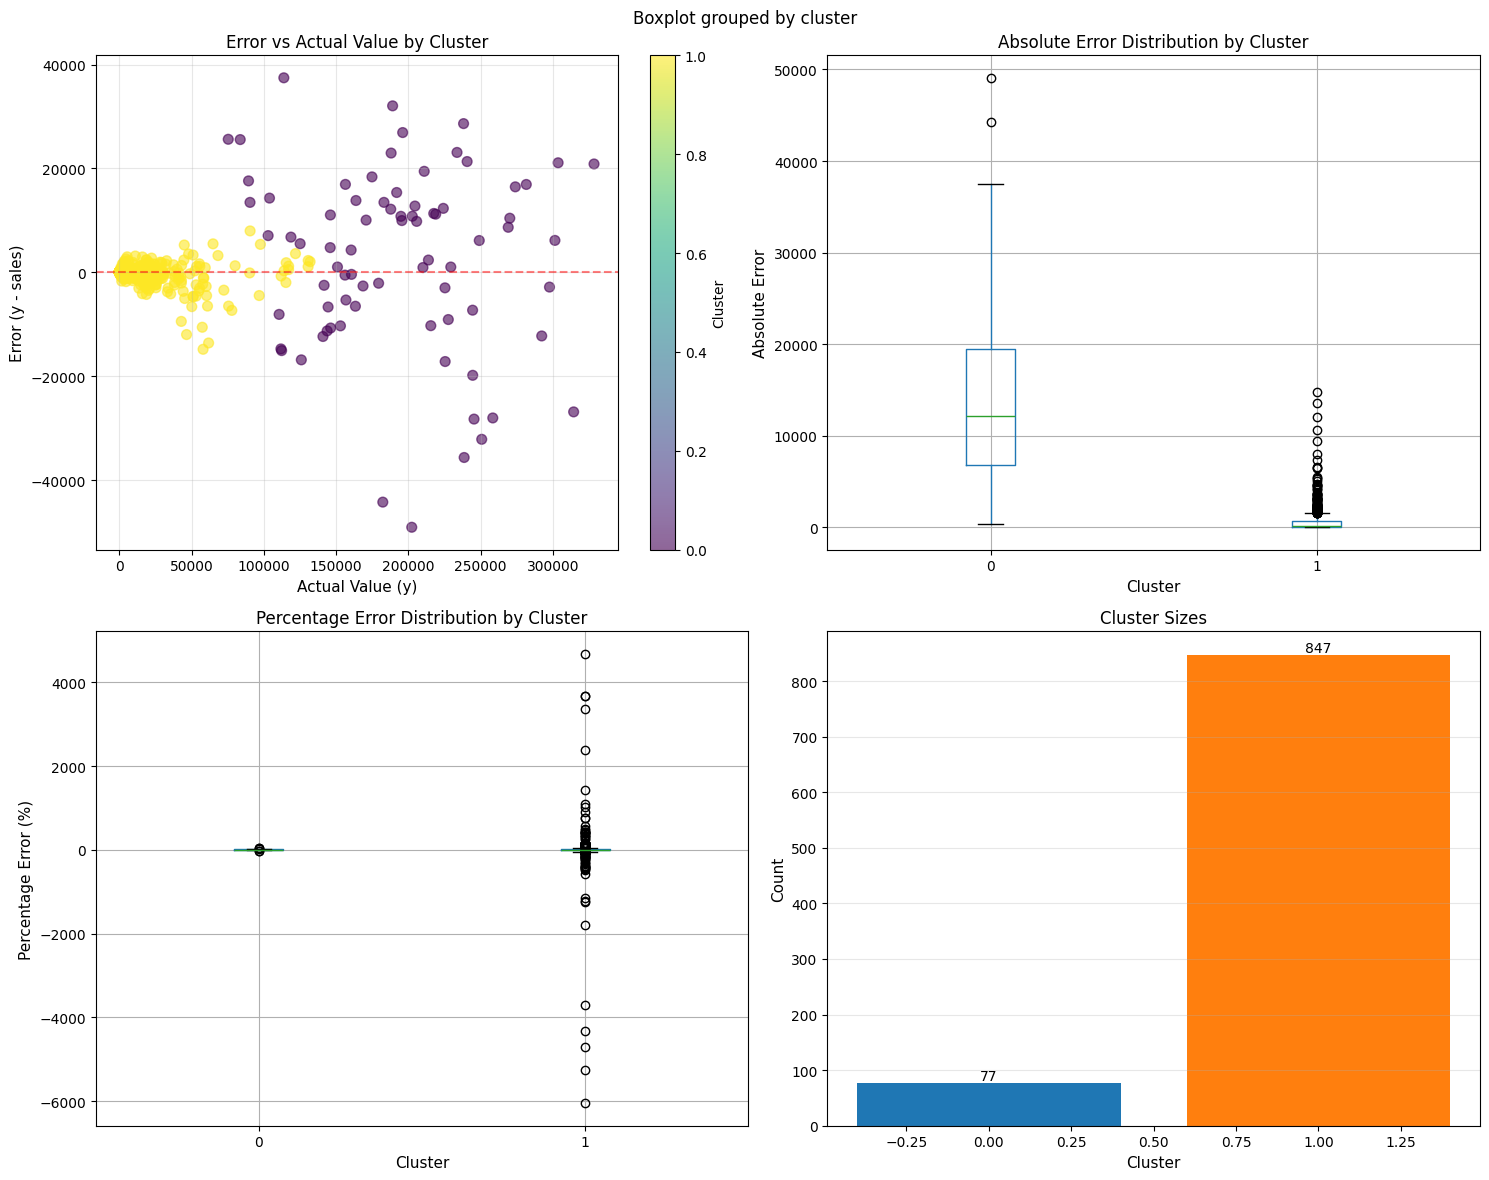


=== Detailed Cluster Statistics ===
           error                               abs_error           pct_error  \
            mean       std       min       max      mean       std      mean   
cluster                                                                        
0        2548.41  17525.60 -49088.64  37441.85  14298.90  10323.66      2.11   
1        -157.09   1462.95 -14823.65   7965.50    631.71   1328.68     -5.07   

                         y      sales      family  
            std       mean       mean    <lambda>  
cluster                                            
0         10.71  192317.84  189769.43   BEVERAGES  
1        490.91   10187.01   10344.10  AUTOMOTIVE  

✓ Clustering complete! Check the plots and statistics above.


In [16]:

# Perform clustering with chosen k (adjust based on elbow plot)
k_optimal = 2
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
test_fe['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
print("\n=== Cluster Analysis ===")
for i in range(k_optimal):
    cluster_data = test_fe[test_fe['cluster'] == i]
    print(f"\nCluster {i} (n={len(cluster_data)}, {len(cluster_data)/len(test_fe)*100:.1f}%):")
    print(f"  Mean Error: {cluster_data['error'].mean():.2f}")
    print(f"  Mean Abs Error: {cluster_data['abs_error'].mean():.2f}")
    print(f"  Mean % Error: {cluster_data['pct_error'].mean():.2f}%")
    print(f"  Mean Actual (y): {cluster_data['y'].mean():.2f}")
    print(f"  Mean Prediction (sales): {cluster_data['sales'].mean():.2f}")
    print(f"  Top families: {cluster_data['family'].value_counts().head(50).to_dict()}")

# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Error vs Actual Values by Cluster
scatter = axes[0, 0].scatter(test_fe['y'], test_fe['error'], 
                            c=test_fe['cluster'], cmap='viridis', 
                            alpha=0.6, s=50)
axes[0, 0].set_xlabel('Actual Value (y)', fontsize=11)
axes[0, 0].set_ylabel('Error (y - sales)', fontsize=11)
axes[0, 0].set_title('Error vs Actual Value by Cluster', fontsize=12)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster')

# Absolute Error Distribution
test_fe.boxplot(column='abs_error', by='cluster', ax=axes[0, 1])
axes[0, 1].set_title('Absolute Error Distribution by Cluster', fontsize=12)
axes[0, 1].set_xlabel('Cluster', fontsize=11)
axes[0, 1].set_ylabel('Absolute Error', fontsize=11)
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# Percentage Error Distribution
test_fe.boxplot(column='pct_error', by='cluster', ax=axes[1, 0])
axes[1, 0].set_title('Percentage Error Distribution by Cluster', fontsize=12)
axes[1, 0].set_xlabel('Cluster', fontsize=11)
axes[1, 0].set_ylabel('Percentage Error (%)', fontsize=11)
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# Cluster sizes
cluster_counts = test_fe['cluster'].value_counts().sort_index()
bars = axes[1, 1].bar(cluster_counts.index, cluster_counts.values, 
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:k_optimal])
axes[1, 1].set_xlabel('Cluster', fontsize=11)
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].set_title('Cluster Sizes', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Detailed summary statistics by cluster
summary = test_fe.groupby('cluster').agg({
    'error': ['mean', 'std', 'min', 'max'],
    'abs_error': ['mean', 'std'],
    'pct_error': ['mean', 'std'],
    'y': 'mean',
    'sales': 'mean',
    'family': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A'
}).round(2)

print("\n=== Detailed Cluster Statistics ===")
print(summary)

# Export clustered data (optional)
# test_fe.to_csv('test_with_clusters.csv', index=False)
print("\n✓ Clustering complete! Check the plots and statistics above.")

Index(['family', 'date', 'y', 'sales'], dtype='object')
Original test data shape: (924, 4)

Aggregated data shape: (924, 4)
Families: 33, Dates: 28

=== Aggregated Error Summary ===
Mean Error: 68.36
Mean Absolute Error: 1770.64
Mean Percentage Error: -4.47%
RMSE: 5271.29

=== Error Summary by Family ===
                              error  abs_error  pct_error
family                                                   
AUTOMOTIVE                    20.20      50.41       4.08
BABY CARE                      2.50      32.12      46.55
BEAUTY                       -33.30      80.72     -10.51
BEVERAGES                   -117.43   14809.75       0.23
BOOKS                         -6.36      33.29    -263.78
BREAD/BAKERY                -303.27    1217.33      -0.94
CELEBRATION                   28.76     137.51       1.56
CLEANING                    2379.37    8681.80       0.96
DAIRY                      -1447.74    2801.51      -3.17
DELI                        -521.51     740.41      -2.9

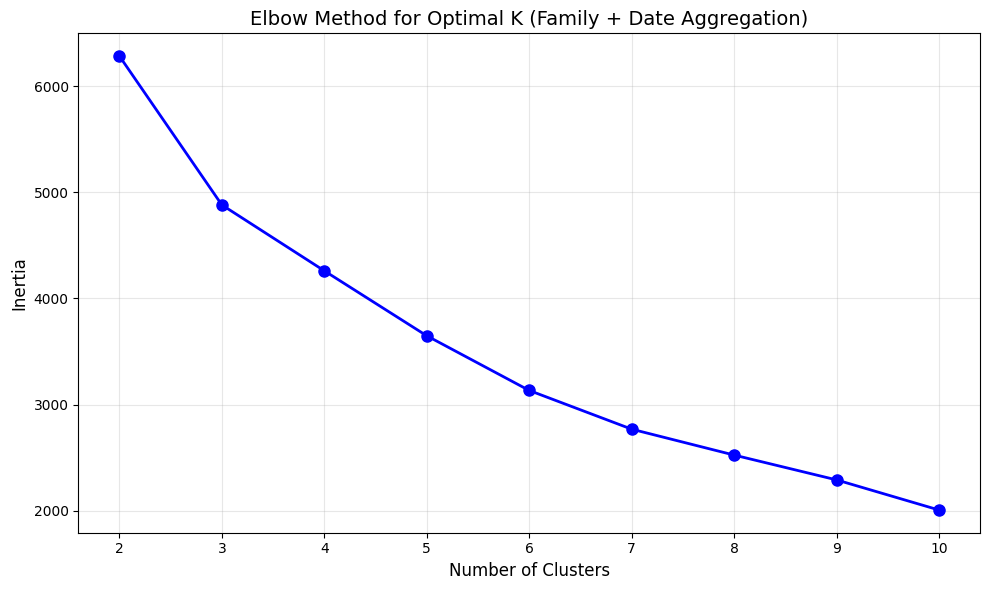


=== Cluster Analysis (Family + Date Level) ===

Cluster 0 (n=845, 91.5%):
  Mean Error: -162.57
  Mean Abs Error: 628.11
  Mean % Error: -5.09%
  Mean Actual (y): 9900.24
  Mean Prediction (sales): 10062.81
  Top families: {'AUTOMOTIVE': 28, 'BABY CARE': 28, 'SCHOOL AND OFFICE SUPPLIES': 28}
  Day of week distribution: {0: 123, 1: 121, 2: 119, 3: 123, 4: 120, 5: 120, 6: 119}

Cluster 1 (n=79, 8.5%):
  Mean Error: 2538.44
  Mean Abs Error: 13991.45
  Mean % Error: 2.10%
  Mean Actual (y): 190774.21
  Mean Prediction (sales): 188235.77
  Top families: {'BEVERAGES': 28, 'GROCERY I': 28, 'PRODUCE': 16}
  Day of week distribution: {0: 9, 1: 11, 2: 13, 3: 9, 4: 12, 5: 12, 6: 13}


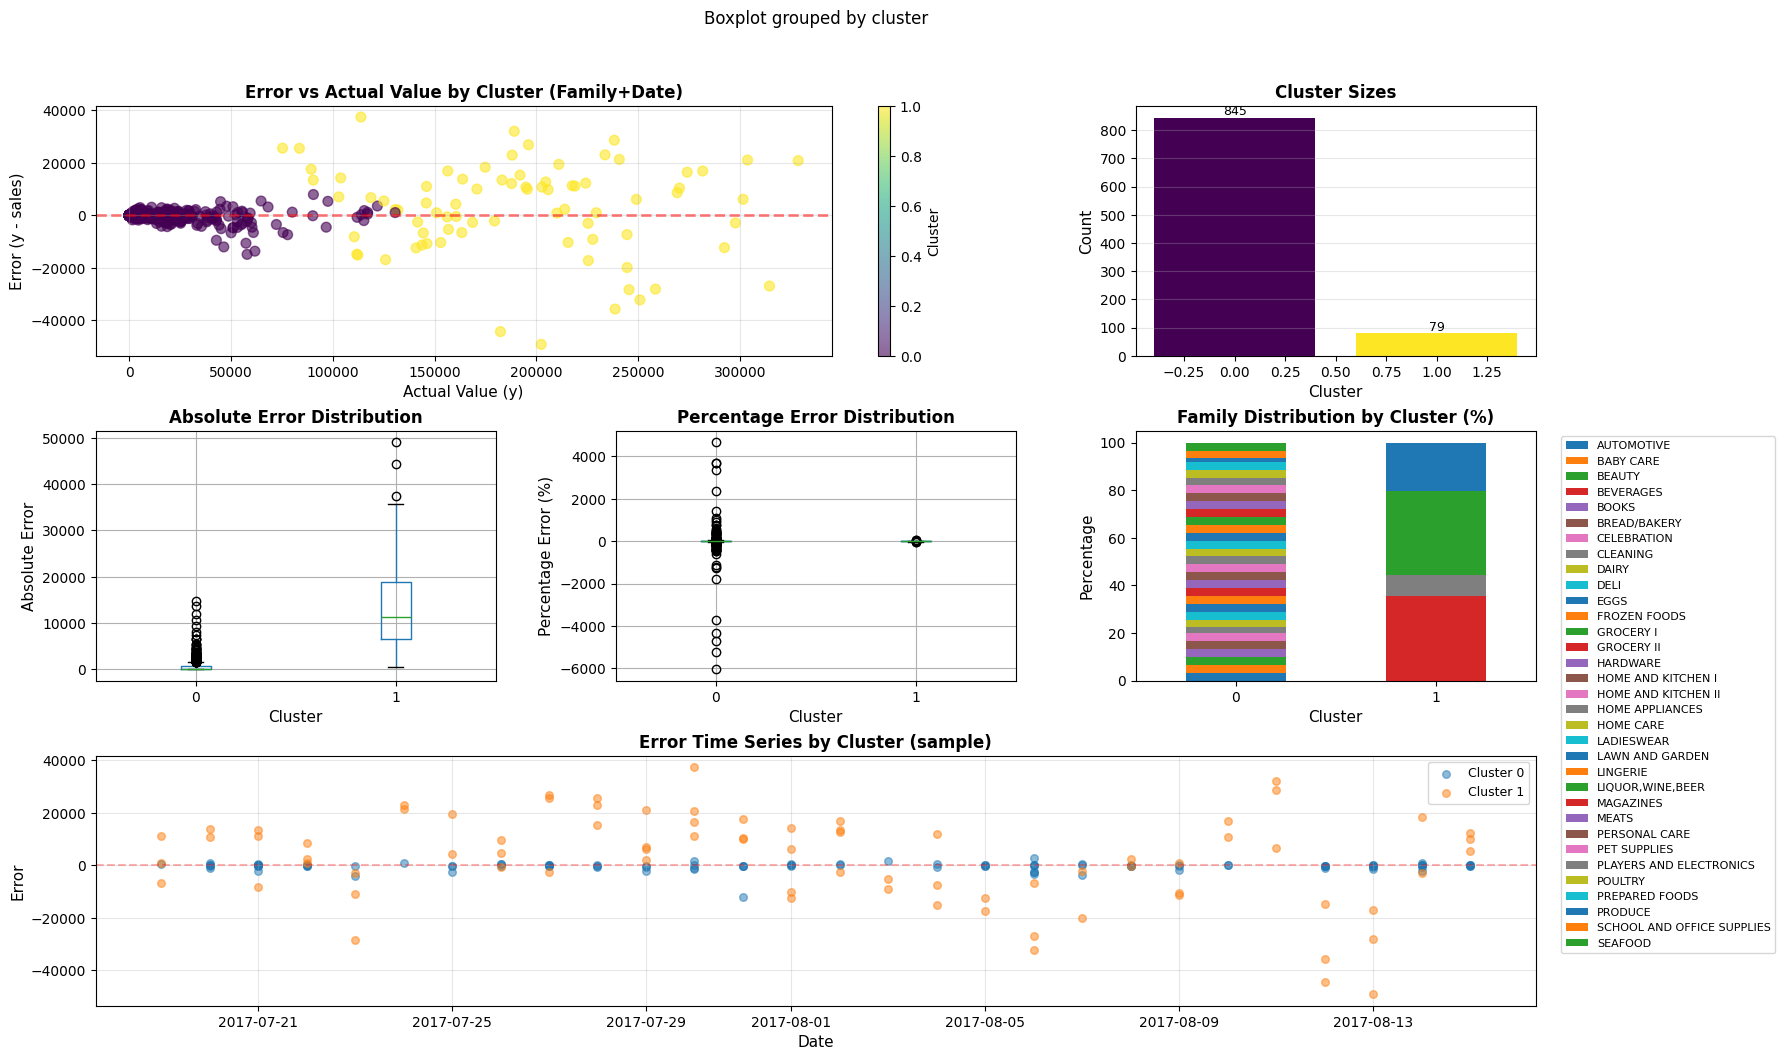


=== Detailed Cluster Statistics ===
           error                               abs_error           pct_error  \
            mean       std       min       max      mean       std      mean   
cluster                                                                        
0        -162.57   1460.33 -14823.65   7965.50    628.11   1328.17     -5.09   
1        2538.44  17299.58 -49088.64  37441.85  13991.45  10369.73      2.10   

                         y      sales  
            std       mean       mean  
cluster                                
0        491.49    9900.24   10062.81  
1         10.57  190774.21  188235.77  

=== Cluster by Day of Week ===
day_of_week     0     1     2     3     4     5     6
cluster                                              
0            14.6  14.3  14.1  14.6  14.2  14.2  14.1
1            11.4  13.9  16.5  11.4  15.2  15.2  16.5

✓ Clustering complete! Aggregated by family + date across 54 stores.


In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

# Example data structure matching your format

# Load your data
train = pd.read_parquet('../notebooks/data/train.parquet')
train.head(2)
test = pd.read_parquet('notebooks/data/forecast.parquet')
test.rename(columns={'prediction': 'sales'}, inplace=True)
print(test.columns)


print(f"Original test data shape: {test.shape}")
# print(f"Stores: {test['store_nbr'].nunique()}, Families: {test['family'].nunique()}, Dates: {test['date'].nunique()}")

# Aggregate by family + date (sum across all stores)
test_agg = test.groupby(['family', 'date']).agg({
    'y': 'sum',
    'sales': 'sum',
    # 'store_nbr': 'count'  # number of stores
}).reset_index()

test_agg.rename(columns={'store_nbr': 'n_stores'}, inplace=True)

print(f"\nAggregated data shape: {test_agg.shape}")
print(f"Families: {test_agg['family'].nunique()}, Dates: {test_agg['date'].nunique()}")

# Feature engineering
test_agg['date'] = pd.to_datetime(test_agg['date'])
test_agg['day_of_week'] = test_agg['date'].dt.dayofweek
test_agg['month'] = test_agg['date'].dt.month
test_agg['day'] = test_agg['date'].dt.day
test_agg['week_of_year'] = test_agg['date'].dt.isocalendar().week
test_agg['is_weekend'] = test_agg['day_of_week'].isin([5, 6]).astype(int)
test_agg['family_encoded'] = test_agg['family'].astype('category').cat.codes

# Calculate errors
test_agg['error'] = test_agg['y'] - test_agg['sales']
test_agg['abs_error'] = np.abs(test_agg['error'])
test_agg['pct_error'] = (test_agg['error'] / test_agg['y']) * 100
test_agg['pct_error'] = test_agg['pct_error'].replace([np.inf, -np.inf], 0)

# Calculate relative error magnitude
# test_agg['error_per_store'] = test_agg['error'] / test_agg['n_stores']
# test_agg['abs_error_per_store'] = test_agg['abs_error'] / test_agg['n_stores']

print("\n=== Aggregated Error Summary ===")
print(f"Mean Error: {test_agg['error'].mean():.2f}")
print(f"Mean Absolute Error: {test_agg['abs_error'].mean():.2f}")
print(f"Mean Percentage Error: {test_agg['pct_error'].mean():.2f}%")
print(f"RMSE: {np.sqrt((test_agg['error']**2).mean()):.2f}")

# Show error summary by family
print("\n=== Error Summary by Family ===")
family_summary = test_agg.groupby('family').agg({
    'error': 'mean',
    'abs_error': 'mean',
    'pct_error': 'mean'
}).round(2)
print(family_summary)

# Prepare features for clustering
cluster_features = ['error', 'abs_error', 'pct_error', 
                   'y', 'sales', 
                #    'error_per_store',
                   'day_of_week', 'month', 'is_weekend', 'family_encoded']
X_cluster = test_agg[cluster_features].copy()

# Handle any missing values
X_cluster = X_cluster.fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal K (Family + Date Aggregation)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perform clustering with chosen k
k_optimal = 2
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
test_agg['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
print("\n=== Cluster Analysis (Family + Date Level) ===")
for i in range(k_optimal):
    cluster_data = test_agg[test_agg['cluster'] == i]
    print(f"\nCluster {i} (n={len(cluster_data)}, {len(cluster_data)/len(test_agg)*100:.1f}%):")
    print(f"  Mean Error: {cluster_data['error'].mean():.2f}")
    print(f"  Mean Abs Error: {cluster_data['abs_error'].mean():.2f}")
    print(f"  Mean % Error: {cluster_data['pct_error'].mean():.2f}%")
    print(f"  Mean Actual (y): {cluster_data['y'].mean():.2f}")
    print(f"  Mean Prediction (sales): {cluster_data['sales'].mean():.2f}")
    print(f"  Top families: {cluster_data['family'].value_counts().head(3).to_dict()}")
    print(f"  Day of week distribution: {cluster_data['day_of_week'].value_counts().sort_index().to_dict()}")

# Create comprehensive visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Error vs Actual Values by Cluster
ax1 = fig.add_subplot(gs[0, :2])
scatter = ax1.scatter(test_agg['y'], test_agg['error'], 
                     c=test_agg['cluster'], cmap='viridis', 
                     alpha=0.6, s=50)
ax1.set_xlabel('Actual Value (y)', fontsize=11)
ax1.set_ylabel('Error (y - sales)', fontsize=11)
ax1.set_title('Error vs Actual Value by Cluster (Family+Date)', fontsize=12, fontweight='bold')
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2)
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster')

# 2. Cluster sizes
ax2 = fig.add_subplot(gs[0, 2])
cluster_counts = test_agg['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, k_optimal))
bars = ax2.bar(cluster_counts.index, cluster_counts.values, color=colors)
ax2.set_xlabel('Cluster', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Cluster Sizes', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 3. Absolute Error Distribution
ax3 = fig.add_subplot(gs[1, 0])
test_agg.boxplot(column='abs_error', by='cluster', ax=ax3)
ax3.set_title('Absolute Error Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Cluster', fontsize=11)
ax3.set_ylabel('Absolute Error', fontsize=11)
plt.sca(ax3)
plt.xticks(rotation=0)

# 4. Percentage Error Distribution
ax4 = fig.add_subplot(gs[1, 1])
test_agg.boxplot(column='pct_error', by='cluster', ax=ax4)
ax4.set_title('Percentage Error Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Cluster', fontsize=11)
ax4.set_ylabel('Percentage Error (%)', fontsize=11)
plt.sca(ax4)
plt.xticks(rotation=0)

# 5. Family distribution per cluster
ax5 = fig.add_subplot(gs[1, 2])
family_cluster = pd.crosstab(test_agg['cluster'], test_agg['family'], normalize='index') * 100
family_cluster.plot(kind='bar', stacked=True, ax=ax5, legend=False)
ax5.set_title('Family Distribution by Cluster (%)', fontsize=12, fontweight='bold')
ax5.set_xlabel('Cluster', fontsize=11)
ax5.set_ylabel('Percentage', fontsize=11)
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.sca(ax5)
plt.xticks(rotation=0)

# 6. Time series of errors by cluster (sample)
ax6 = fig.add_subplot(gs[2, :])
for cluster_id in range(k_optimal):
    cluster_data = test_agg[test_agg['cluster'] == cluster_id].sort_values('date')
    # Sample to avoid overcrowding
    if len(cluster_data) > 100:
        cluster_data = cluster_data.sample(100, random_state=42).sort_values('date')
    ax6.scatter(cluster_data['date'], cluster_data['error'], 
               label=f'Cluster {cluster_id}', alpha=0.5, s=30)
ax6.set_xlabel('Date', fontsize=11)
ax6.set_ylabel('Error', fontsize=11)
ax6.set_title('Error Time Series by Cluster (sample)', fontsize=12, fontweight='bold')
ax6.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax6.legend(loc='best', fontsize=9)
ax6.grid(True, alpha=0.3)

plt.show()

# Detailed summary statistics by cluster
summary = test_agg.groupby('cluster').agg({
    'error': ['mean', 'std', 'min', 'max'],
    'abs_error': ['mean', 'std'],
    'pct_error': ['mean', 'std'],
    'y': 'mean',
    'sales': 'mean'
}).round(2)

print("\n=== Detailed Cluster Statistics ===")
print(summary)

# Cluster characteristics by day of week
print("\n=== Cluster by Day of Week ===")
dow_cluster = pd.crosstab(test_agg['cluster'], test_agg['day_of_week'], normalize='index') * 100
print(dow_cluster.round(1))

# Export clustered data (optional)
# test_agg.to_csv('test_family_date_clusters.csv', index=False)
print("\n✓ Clustering complete! Aggregated by family + date across 54 stores.")